# Lane Detection


In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.color import rgb2lab
from skimage.io import imread
from skimage.filters import threshold_triangle
from skimage.transform import ProjectiveTransform, warp, resize
from skimage.morphology import thin, binary_dilation

from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

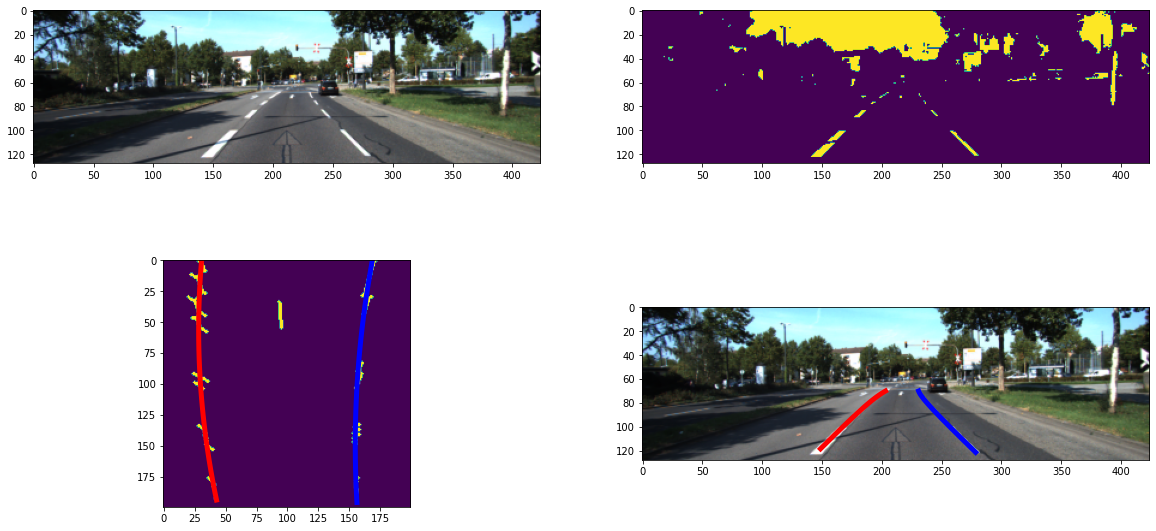

In [155]:
data_dir = 'data/training/image_2/'
cal_dir = 'data/training/calib/'

cal_src = np.array([[0, 0], [0, 200], [200, 200], [200, 0]])
cal_dst = np.array([[197, 70], [82, 128], [342, 128], [237, 70]])

img = imread(data_dir + 'umm_000004.png')
img = resize(img, (128, 424))
img_lab = rgb2lab(img)
l = img_lab[:,:,0]
a = img_lab[:,:,1]
b = img_lab[:,:,2]

# Thresholding l
l_thresh = threshold_triangle(l)
l = l > l_thresh

tform = ProjectiveTransform()
tform.estimate(cal_dst, cal_src)
warped = warp(l, tform.inverse, output_shape=(200, 200))
thin_warped = binary_dilation(thin(warped))

points = np.argwhere(thin_warped == 1)
left_indices = np.argwhere(points[:,1] < 100)
right_indices = np.argwhere(points[:,1] > 100)

X = points[:, 0]
Y = points[:, 1]
model = make_pipeline(PolynomialFeatures(2), RANSACRegressor(random_state=42))
model.fit(X[right_indices], Y[right_indices])
x_plot_right = np.linspace(X[right_indices].min(), X[right_indices].max())
y_plot_right = model.predict(x_plot_right[:, np.newaxis]).reshape(-1)
right = np.stack((y_plot_right, x_plot_right), axis=1)
model.fit(X[left_indices], Y[left_indices])
x_plot_left = np.linspace(X[left_indices].min(), X[left_indices].max())
y_plot_left = model.predict(x_plot_left[:, np.newaxis]).reshape(-1)
left = np.stack((y_plot_left, x_plot_left), axis=1)
right = tform.inverse(right)
left = tform.inverse(left)

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(l)
plt.subplot(223)
plt.imshow(thin_warped)
plt.plot(y_plot_left, x_plot_left, linewidth=5.0, c='r')
plt.plot(y_plot_right, x_plot_right, linewidth=5.0, c='b')
plt.subplot(224)
plt.imshow(img)
plt.plot(left[:,0], left[:,1], linewidth=5.0, c='r')
plt.plot(right[:,0], right[:,1], linewidth=5.0, c='b')

plt.show()